# Homework 4 - Alberto Trashaj
Download the Nile data, available in the R dataset: and fit a LLM to the data. Compare your results with Table 2.1.

### Import libraries
As usual we import the libraries needed to deal with algebra calculation and to plot the result.

In [259]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import pandas as pd

### Functions
Now, as we did in the Lab, we will define the function of the Kalman filter, the likelihood and the estimator function. 

## Kalman filter

In [260]:
np.random.seed(0)

def KF(y, q):
    m20 = y[0]
    P20 = 1 + q

    n = len(y)
    mu_pred = np.empty(n)
    P = np.zeros(n)
    v = np.empty(n)
    K = np.zeros(n)
    F = np.zeros(n)
    dllk = np.empty(n)
    llk = 0

    mu_pred[1] = m20
    P[1] = P20


    for t in range(1, n-1):
        v[t] = y[t] - mu_pred[t]
        F[t] = P[t] + 1
        K[t] = P[t] / F[t]
        P[t + 1] = P[t] * (1 - K[t]) + q
        mu_pred[t + 1] = mu_pred[t] + K[t] * v[t]
        dllk[t] = -0.5 * np.log(F[t])

        print("Iteration:", t)
        print("Likelihood:", -0.5 * np.log(F[t]))
        print("Score:", -K[t])
        print("Signal-to-Noise Ratio (q):", q)
        print()

    #Since we need to define sigma_e_hat and the likelihood 
    # we need the last element computed in the for loop, so we retrieve those values below

    F[n - 1] = P[n - 1] + 1
    K[n - 1] = P[n - 1] / F[n - 1]
    dllk[n - 1] = -0.5 * np.log(F[n - 1])
    v[n - 1] = y[n - 1] - mu_pred[n - 1]

    sigma_e_hat = np.sum(v[1:] ** 2 / F[1:]) / (n - 1)
    llk = -0.5 * (n - 1) * np.log(sigma_e_hat) + np.sum(dllk[1:])

    return {'mu_pred': mu_pred, 'llk': llk, 'v': v, 'F': F}


## Loglikelihood 

In [261]:
def loglikelihood(par, y):
    q_new = par[0]
    obj = KF(y, q_new)['llk']
    return -obj

## Estimator 

Here a mention has to be done with the function minimize: in the book, they used the 'BFGS' algorithm, although to get the most similar result to the table I used the 'Nelder-Mead' method just to be consistent with the table 2.1. 
If in the method argument we put 'BFGS' the algorithm converges but not with the same result of the table.

In [262]:
#This uses the Nelder-Mead method
def estimator(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='Nelder-Mead') #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out

In [263]:
##This uses the BFGS method
def estimator_bfgs(y, par):
    n = len(y)
    q_0 = par

    hat = minimize(loglikelihood, q_0, args=(y,), method='BFGS') #here the method used is the Nelder-Mead although in the book they use BFGS 

    q_hat = hat.x[0]
    theta_list = {'q_hat': q_hat, 'iter': hat.nit}
    out = {'theta_list': theta_list}
    return out


In [264]:
#Load the dataset
np.random.seed(0)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# uncomment those lines above if you get an  URL error message


from statsmodels.datasets import get_rdataset
data = get_rdataset('Nile').data

#data = pd.read_csv("/Users/albertotrashaj/Desktop/Advanced-time-series-github/Assignement 4/Nile.csv")
y = np.array(data['value'])
n = len(y)

q_0 = 1
est = estimator(y, q_0)

#est = estimator_bfgs(y, q_0) uncomment this line and comment the above one to get the result with the BFGS algorithm

q_hat = est['theta_list']['q_hat']

filter_output = KF(y, q_hat)
sigma_e_hat = np.sum(filter_output['v'][1:] ** 2 / filter_output['F'][1:]) / (n - 1)
sigma_eta_hat = q_hat * sigma_e_hat


print("The value of sigma_e_hat is ", sigma_e_hat)
print("The value of sigma_eta_hat is ", sigma_eta_hat)

Iteration: 1
Likelihood: -0.5493061443340549
Score: -0.6666666666666666
Signal-to-Noise Ratio (q): 1.0

Iteration: 2
Likelihood: -0.49041462650586315
Score: -0.625
Signal-to-Noise Ratio (q): 1.0

Iteration: 3
Likelihood: -0.4825404480217935
Score: -0.6190476190476191
Signal-to-Noise Ratio (q): 1.0

Iteration: 4
Likelihood: -0.48140537375452397
Score: -0.6181818181818182
Signal-to-Noise Ratio (q): 1.0

Iteration: 5
Likelihood: -0.4812400571717648
Score: -0.6180555555555556
Signal-to-Noise Ratio (q): 1.0

Iteration: 6
Likelihood: -0.48121594393600503
Score: -0.6180371352785146
Signal-to-Noise Ratio (q): 1.0

Iteration: 7
Likelihood: -0.48121242599273545
Score: -0.6180344478216818
Signal-to-Noise Ratio (q): 1.0

Iteration: 8
Likelihood: -0.4812119127345054
Score: -0.6180340557275542
Signal-to-Noise Ratio (q): 1.0

Iteration: 9
Likelihood: -0.481211837851198
Score: -0.6180339985218034
Signal-to-Noise Ratio (q): 1.0

Iteration: 10
Likelihood: -0.48121182692587194
Score: -0.6180339901755971


/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_34919/225816577.py:26: RuntimeWarning: invalid value encountered in log
  dllk[t] = -0.5 * np.log(F[t])
/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_34919/225816577.py:29: RuntimeWarning: invalid value encountered in log
  print("Likelihood:", -0.5 * np.log(F[t]))


### Comment
From the output we can see that the value for the likelihood and the score are different, but the q-ratio and the final values are almost the same of the table 2.1.

# Point 2
Reproduce the Simulation example on Section 2.6.

To riproduce the example on section 2.6. we need to define a data generating process function according to the one used in the book

In [270]:
from math import sqrt

def dgp (n, sigma_e, sigma_eta):
    
    eta = sqrt(sigma_eta)*np.random.normal(0, 1, n)
    e = sqrt(sigma_e)*np.random.normal(0, 1, n)

    alpha = np.zeros(n)
    y = np.zeros(n)

    for t in range(0, n-1):
        alpha[t+1] = alpha[t] + eta[t]
        y[t+1] = alpha[t+1] + e[t+1]

    out = {'y': np.asarray(y), 'alpha': np.asarray(alpha), 'e': e}

    return out

result = dgp(n, sigma_e_hat, sigma_eta_hat)
y_plus = result['y']
e_plus = result['e']
y_plus


array([   0.        ,   17.50475964,  249.51929342,  -58.42685351,
        -26.26694189,   14.26775423,   92.85579085,  145.0240951 ,
        166.5872957 ,   70.33594795,   10.49309685,  134.50872238,
        130.45579258, -133.66272259,  420.48044864,  297.23308397,
         24.3047061 ,  100.00642529,  151.97339734,  -23.68549327,
         90.94578664,  175.85413364,  -57.71192625,  -23.02373088,
        122.15381218,  131.17690497,  157.71179277,  -12.1618656 ,
        -72.95987367, -240.22091904, -155.33460244,  -37.6150268 ,
         63.19967588,   19.21856319,  -87.79762633,  -76.53924727,
         24.36918177,   45.05315983,  237.42366805,   98.25777789,
       -169.80964731,  -80.19528163,  274.374589  ,  -32.85596429,
        247.72620991,  175.7377447 ,  203.88977475,  224.95890344,
        368.56061994,  196.04872458,  182.91674234,  -28.6842548 ,
        150.5742501 ,  184.45126325,  188.7874915 ,  452.69614124,
        294.96449617,  273.24801311,  487.55571217,   82.99526

To find the Kalaman filter vectors we need to define again a function that performs a Kalman filter iteration. Special mention here has to be done for the expression in 2.30 of the book where they define $L_t = 1 - K_t$

In [272]:
def KFL (y, sigma_e, sigma_eta):
    m10 = y[0]
    p10 = sigma_e 

    n = len(y)
    mu_pred = np.zeros(n)
    P = np.zeros(n)
    v = np.zeros(n)
    K = np.zeros(n)
    F = np.zeros(n)
    L = np.zeros(n)
    mu_pred[0] = m10
    P[0] = p10

 

    for t in range(0, n-1):
        v[t] = y[t] - mu_pred[t]; 
        F[t] = P[t] + sigma_e;
        K[t] = P[t]/F[t]
        P[t+1] = P[t] + sigma_eta - K[t]*F[t]*K[t]
        mu_pred[t+1] = mu_pred[t] + K[t]*v[t]
        L[t] = 1 - K[t]


    F[n-1] <- P[n-1] + sigma_e
    K[n-1] <- P[n-1]/F[n-1]
    v[n-1] <- y[n-1] - mu_pred[n-1]
    L[n-1] <- 1 - K[n-1]


    out = {'mu_pred': mu_pred, 'v': v, 'F': F, 'K': K, 'P': P, 'L': L}
    
    return out


    

Now we apply the Kalman filter to the values of the Nile dataset.

In [273]:
filter2 = KFL(y, sigma_e_hat, sigma_eta_hat)



/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_34919/3994716673.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  K[n-1] <- P[n-1]/F[n-1]


Now we perform the recursion for $r_t$ and $u_t$ 

We first define the backward recursion of $r_t$ as in expression 2.36: namely 

$r_{t-1} = \frac{v_t}{F_t} + L_t \cdot r_t$

In [274]:
v = filter2['v'] 
F = filter2['F']
L = filter2['L']
r2 = np.zeros(n)

for t in range(n-2, 0, -1):
    r2[t-1] = v[t] / F[t] + L[t] * r2[t]
r2

array([-0.00087115, -0.00404057,  0.00544384, -0.00090046, -0.00402096,
       -0.00753257,  0.01120411,  0.0034137 , -0.01331654, -0.01610969,
       -0.01086676, -0.00270715, -0.00640067, -0.00303435, -0.0016851 ,
        0.00347391, -0.00559924,  0.01001568,  0.0160746 ,  0.01164362,
        0.01099426,  0.00412924,  0.0016395 , -0.00731352, -0.01764017,
       -0.0270335 , -0.02647304, -0.03312341, -0.02140539, -0.01614038,
       -0.01469702, -0.00276222, -0.00738806, -0.00564615,  0.00428861,
        0.00040158,  0.01138858,  0.00176067, -0.00968281, -0.01670367,
       -0.01620982, -0.01033873,  0.01240818,  0.01199025,  0.02081831,
        0.00398818, -0.01112949, -0.0095807 , -0.00446031, -0.00354872,
        0.00052776, -0.00044395, -0.00271716, -0.00512221,  0.00283585,
        0.00133429,  0.00665149,  0.00917182, -0.00357527,  0.00193983,
        0.0061866 ,  0.00547201,  0.0066142 ,  0.0018432 , -0.00539762,
       -0.00740165, -0.00515854, -0.01586795, -0.01229239, -0.00

Here we define the recursion of $u_t$ as in expression 2.45: namely

$u_t = \frac{v_t}{F_t} - K_t \cdot r_t$

In [275]:
v = filter2['v'] 
F = filter2['F']
K = filter2['K']
u2 = np.zeros(n)

for t in range (1, n-1):
    u2[t] = v[t]/F[t] - K[t]*r2[t]
u2


array([ 0.        ,  0.00316941, -0.0094844 ,  0.0063443 ,  0.00312051,
        0.00351161, -0.01873669,  0.00779042,  0.01673024,  0.00279315,
       -0.00524293, -0.00815961,  0.00369352, -0.00336631, -0.00134926,
       -0.00515901,  0.00907316, -0.01561492, -0.00605892,  0.00443098,
        0.00064936,  0.00686502,  0.00248974,  0.00895302,  0.01032665,
        0.00939333, -0.00056047,  0.00665038, -0.01171803, -0.005265  ,
       -0.00144336, -0.0119348 ,  0.00462584, -0.0017419 , -0.00993476,
        0.00388702, -0.010987  ,  0.00962791,  0.01144348,  0.00702086,
       -0.00049385, -0.00587108, -0.02274691,  0.00041793, -0.00882807,
        0.01683013,  0.01511767, -0.00154879, -0.00512039, -0.00091159,
       -0.00407648,  0.00097171,  0.00227321,  0.00240504, -0.00795806,
        0.00150156, -0.0053172 , -0.00252033,  0.01274709, -0.0055151 ,
       -0.00424677,  0.0007146 , -0.00114219,  0.004771  ,  0.00724082,
        0.00200403, -0.00224311,  0.01070941, -0.00357556, -0.00

Now it's possible to define the smoothed disturbaces $\hat{\epsilon_t} = E(\epsilon_t | Y_n)$

$\hat{\epsilon_t} = \sigma^2 \cdot u_t$

where $\sigma$ is the "sigma_e_hat" that we found before.

In [276]:
e_hat = u2 * sigma_e_hat
e_hat

array([   0.        ,   47.85640531, -143.20938384,   95.79547679,
         47.11794434,   53.0233682 , -282.9138569 ,  117.63112489,
        252.61757156,   42.17502422,  -79.16534304, -123.20577686,
         55.77010242,  -50.82950442,  -20.37307478,  -77.89824499,
        136.99976331, -235.77686079,  -91.48646861,   66.90543502,
          9.80493761,  103.65812357,   37.59368172,  135.18581281,
        155.92687648,  141.83426524,   -8.46274754,  100.41710525,
       -176.93590946,  -79.49870599,  -21.79399384, -180.20908813,
         69.847668  ,  -26.30179879, -150.00952648,   58.69197549,
       -165.89781087,  145.37624851,  172.79041956,  106.01115877,
         -7.45686041,  -88.65017578, -343.4661059 ,    6.31051853,
       -133.29906052,  254.125944  ,  228.26866729,  -23.38591483,
        -77.31514257,  -13.76447597,  -61.55261973,   14.67228248,
         34.32429342,   36.3148782 , -120.16234768,   22.67276058,
        -80.28685092,  -38.05561317,  192.47412159,  -83.27502

Again, as before we apply the Kalman filter to the sample Y

In [277]:
filter3 = KFL(y_plus, sigma_e_hat, sigma_eta_hat)

/var/folders/4z/ffhfh8nj0zz1mqdx8xrwbjfr0000gn/T/ipykernel_34919/3994716673.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  K[n-1] <- P[n-1]/F[n-1]


As before now we proceed to compute $r_t$ and $u_t$.

For $r_t$ we have

In [278]:
v = filter3['v'] 
F = filter3['F']
L = filter3['L']
r3 = np.zeros(n)

for t in range(n-2, 0, -1):
    r3[t-1] = v[t] / F[t] + L[t] * r3[t]

r3

array([ 0.00513487,  0.00704245, -0.00573073,  0.0013332 ,  0.00639694,
        0.00939836,  0.00810924,  0.00415388, -0.00082552,  0.00048926,
        0.00581489,  0.00349285,  0.00177896,  0.01773002, -0.00129393,
       -0.01228137, -0.00638799, -0.00612948, -0.00990881, -0.00301846,
       -0.00401345, -0.01102209, -0.00363429,  0.0011027 , -0.0036678 ,
       -0.00939263, -0.01778838, -0.01666402, -0.01313399,  0.00019584,
        0.00792291,  0.00862433,  0.00348789,  0.00160346,  0.00696242,
        0.01225296,  0.01205238,  0.01165423, -0.00035059, -0.00317289,
        0.01144963,  0.02125088,  0.00963681,  0.0193072 ,  0.01227325,
        0.01120068,  0.00935312,  0.00701993, -0.00414084, -0.00427934,
       -0.00396437,  0.00997882,  0.01302075,  0.01508556,  0.01833051,
        0.00588036,  0.00444834,  0.00488723, -0.00839159,  0.00430641,
        0.01019539,  0.00122778, -0.00048378, -0.00070944, -0.00203526,
        0.00030572, -0.00890791, -0.00895551, -0.00879347, -0.00

For $u_t$ instead

In [302]:
v = filter3['v'] 
F = filter3['F']
K = filter3['K']
u3 = np.zeros(n)

for t in range (1, n-1):
    u3[t] = v[t]/F[t] - K[t]*r3[t]
u3

array([ 0.00000000e+00, -1.90758303e-03,  1.27731778e-02, -7.06393175e-03,
       -5.06373527e-03, -3.00142489e-03,  1.28912873e-03,  3.95535668e-03,
        4.97940448e-03, -1.31478922e-03, -5.32562195e-03,  2.32203792e-03,
        1.71388833e-03, -1.59510599e-02,  1.90239515e-02,  1.09874382e-02,
       -5.89337873e-03, -2.58508992e-04,  3.77932305e-03, -6.89034505e-03,
        9.94993748e-04,  7.00863484e-03, -7.38779776e-03, -4.73699273e-03,
        4.77050221e-03,  5.72483025e-03,  8.39575038e-03, -1.12436421e-03,
       -3.53003003e-03, -1.33298303e-02, -7.72706815e-03, -7.01418519e-04,
        5.13643924e-03,  1.88442695e-03, -5.35895275e-03, -5.29054194e-03,
        2.00582269e-04,  3.98149100e-04,  1.20048168e-02,  2.82230408e-03,
       -1.46225256e-02, -9.80124319e-03,  1.16140635e-02, -9.67038736e-03,
        7.03394988e-03,  1.07256647e-03,  1.84756445e-03,  2.33318388e-03,
        1.11607724e-02,  1.38497067e-04, -3.14969465e-04, -1.39431841e-02,
       -3.04193232e-03, -

Now we need to define the following variables:

$\hat{\epsilon}^{+}$ 

$\tilde{\epsilon}$

$\hat{\alpha}$

$\alpha^{+}$

$\tilde{\alpha}$




In [301]:
e_hat_plus = u3 * sigma_e_hat
e_hat_plus

array([   0.        ,  -28.80347589,  192.86810248, -106.66156334,
        -76.45967422,  -45.3198986 ,   19.46514925,   59.72375463,
         75.1863247 ,  -19.85260873,  -80.41402189,   35.06152146,
         25.87879029, -240.85240954,  287.25141689,  165.90439601,
        -88.9868433 ,   -3.90334649,   57.06574175, -104.04049763,
         15.02386948,  105.82660974, -111.55176556,  -71.5260378 ,
         72.0320129 ,   86.44185207,  126.77130701,  -16.9772938 ,
        -53.3015514 , -201.27325502, -116.67456561,  -10.59104171,
         77.55746495,   28.45383153,  -80.91729901,  -79.88433263,
          3.02868419,    6.01183689,  181.26626482,   42.61527091,
       -220.79225708, -147.99349107,  175.36610049, -146.01763851,
        106.20885311,   16.1951758 ,   27.89722765,   35.22981942,
        168.5216494 ,    2.09123108,   -4.75586922, -210.53456701,
        -45.93153901,  -31.17756262,  -48.99687623,  187.99051987,
         21.62263656,   -6.62694548,  200.50308059, -191.73298

Formula 2.53

In [300]:
e_tilde = e_plus - e_hat_plus + e_hat
e_tilde

array([-135.73513821,   72.85843809, -142.06674462,  104.70604006,
         53.97356589,   60.53420422, -269.3213644 ,  122.40920639,
        333.1706197 ,  123.40590837,   -6.37640085,   -3.54101163,
        116.41237937,    6.23400831,    2.81529625,  -26.31494004,
        205.31646565, -185.43597207,   14.18481384,  149.78592252,
         84.52659741,  133.56196738,   24.4437769 ,  132.69739385,
        197.11740297,  112.01723384,  -21.71805808,  101.10445933,
       -159.14727932, -123.8179996 ,  -45.93980575, -163.83457107,
         93.61168275,   10.51549557,  -84.8505839 ,  105.18105476,
       -142.23949116,  148.97499099,  164.11451779,   81.39050994,
         31.32009304,  -97.02845634, -332.20726433,    8.41611783,
       -145.56656993,  204.95316277,  179.51156343,  -75.09795246,
        -95.75317323,  -39.55208488,  -60.89101948,   37.10192263,
        105.65393457,  132.7468723 ,  -41.77929483,    6.45554434,
        -95.13003886,    5.30964172,  194.53899097,  -82.00757

In [299]:
alpha_tilde = y - e_tilde
eta_tilde = np.diff(alpha_tilde)


In [283]:
alpha = pd.Series(filter2['mu_pred'])

alpha_hat = np.zeros(n)
alpha_hat[0] = alpha[0]
alpha_hat[1] = alpha[1]

for t in range(1, n):
    alpha_hat[t] = alpha[t] + filter2['P'][t] * r2[t-1]
    


In [285]:
alpha_plus = np.zeros(n)

for t in range(1, n):
    alpha_plus[t] = y_plus[t] - e_plus[t]

alpha_plus

array([   0.        ,   21.30620275,   55.50855173,   39.32414656,
         43.33711078,   52.07681681,   59.7981491 ,   80.52225896,
         10.84792286,    8.95767253,   18.11817657,  -20.21756432,
         43.93472535,   50.12617421,  110.04066073,   79.74538301,
         44.97484706,   53.56888307,  -10.76362686,   -2.52548314,
          1.20025735,   40.1236801 ,   66.98974413,   50.99072587,
          8.93127279,   74.55208431,   44.1957963 ,    4.12807412,
        -37.44695241,    5.37162958,  -14.51422493,  -43.39850215,
        -38.12180382,  -46.0525627 ,  -72.0392699 ,  -43.14399391,
         -2.31782213,   35.44258047,   64.83330501,   80.26315581,
         12.20565632,   76.17649001,   87.74964695,  111.05607492,
        153.78486621,  208.71535013,  224.74965096,  241.44112166,
        218.4770012 ,  219.74510241,  187.01101132,  159.42067206,
        125.17614796,  119.19683176,  159.40131487,  280.92283762,
        288.18504756,  236.50970372,  284.9877622 ,  273.46079

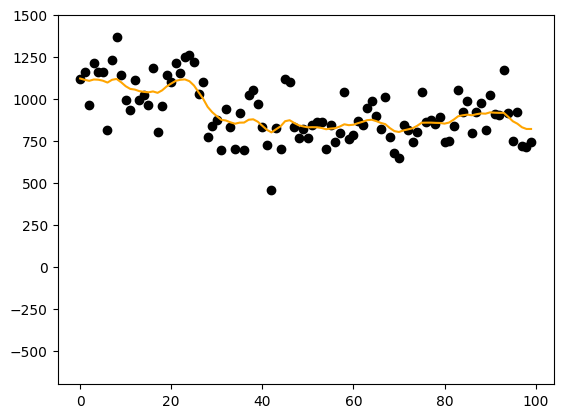

In [298]:
# Graph i

plt.plot(y, 'ko',linestyle =  'None')
plt.ylim(-700, 1500)
plt.plot(alpha_hat, color='orange')

plt.show()

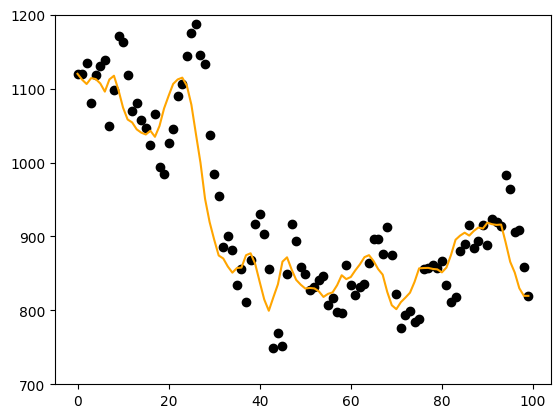

In [290]:
# Graph ii
plt.plot(alpha, 'ko',linestyle =  'None')
plt.ylim(700, 1200)
plt.plot(alpha_hat, color='orange')

plt.show()

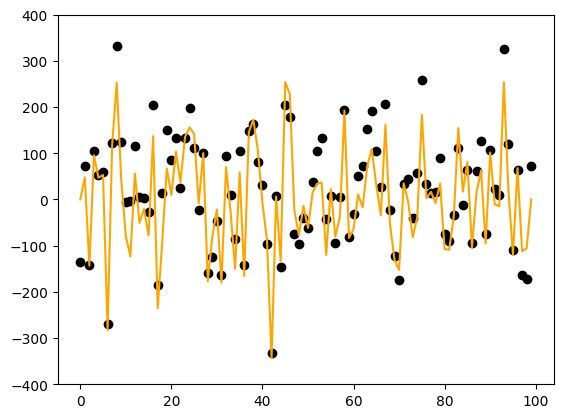

In [291]:
# Graph iii

plt.plot(e_tilde, 'ko',linestyle =  'None')
plt.ylim(-400, 400)
plt.plot(e_hat, color='orange')

plt.show()

In [292]:
eta_tilde = np.diff(alpha_tilde)

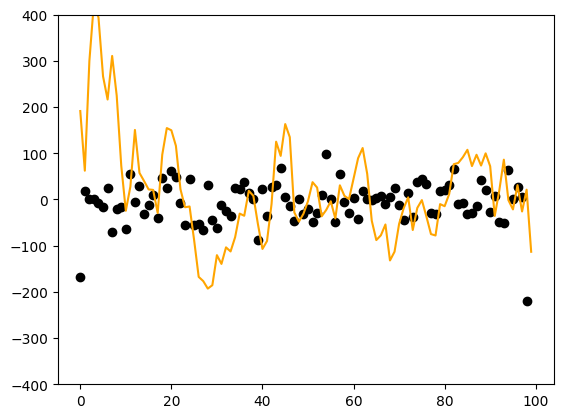

In [293]:
# Graph iiii

plt.plot(eta_tilde, 'ko',linestyle =  'None')
plt.ylim(-400, 400)
plt.plot(eta_hat, color='orange')

plt.show()